In [1]:
import sys
import os
# Add the directory containing 'thesis_utils.py' to the system path
sys.path.append(os.path.abspath('..'))  # If 'thesis_utils.py' is one level up
# Or use this if it's in the same directory as the notebook:
# sys.path.append(os.getcwd())
# os.environ["JULIA_NUM_THREADS"] = "8" 
os.environ["PYTHON_JULIACALL_HANDLE_SIGNALS"] = "yes"
os.environ["PYTHON_JULIACALL_THREADS"] = "auto"
os.environ["PYTHON_JULIACALL_OPTLEVEL"] = "3"
from pysr import PySRRegressor
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport

from thesis_utils import *

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [22]:
import importlib
import thesis_utils  # or whatever your module is called

importlib.reload(thesis_utils)

from thesis_utils import *

In [2]:
data = pd.read_csv("C:/Users/svenl/vs_code_projects/hyperRealDataDescriber/data/insurance/insurance_original.csv")
# encode categorical column 'smoker' with only two categories to numerical representation as this one is highly correlated with 'charges' column
data['smoker'] = data['smoker'].map({'yes': 1, 'no': 0})

In [3]:
# Generate the profiling report
profile_full = ProfileReport(data, title="Insurance Original", explorative=True)

# Get the description object
desc_full = profile_full.get_description()

# Access the correlation matrix
correlation_matrix = desc_full.correlations["auto"]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

In [4]:
categorical_cols = get_categorical_columns(data)
distributions = fit_distributions(data)
marginals = convert_distfit_to_marginals(distributions, data)

In [5]:
data_syn = generate_synthetic_dataset(original_data=data, correlation_matrix=correlation_matrix, categorical_columns=categorical_cols, marginals=marginals, n_rows=2000, correlation_threshold=0.1, edge_strategy="random", sampling_strategy="local-chunks")

In [6]:
# Generate the profiling report
profile_syn = ProfileReport(data_syn, title="Insurance SYN", explorative=True)

# Get the description object
desc_syn = profile_syn.get_description()

# Access the correlation matrix
correlation_matrix_syn = desc_syn.correlations["auto"]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

In [7]:
plot_correlation_matrices(correlation_matrix, correlation_matrix_syn, "Real", "Synthetic")

In [8]:
from sdmetrics.reports.single_table import QualityReport

data_syn = data_syn[data.columns.to_list()]

metadata = {
    "columns": {
        "age": {"sdtype": "numerical"},
        "sex": {"sdtype": "categorical"},
        "bmi": {"sdtype": "numerical"},
        "children": {"sdtype": "numerical"},
        "smoker": {"sdtype": "numerical"},
        "region": {"sdtype": "categorical"},
        "charges": {"sdtype": "numerical"},
    }
}

report = QualityReport()
report.generate(data, data_syn, metadata)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 7/7 [00:00<00:00, 348.05it/s]|
Column Shapes Score: 90.91%

(2/2) Evaluating Column Pair Trends: |██████████| 21/21 [00:00<00:00, 226.31it/s]|
Column Pair Trends Score: 87.53%

Overall Score (Average): 89.22%



In [9]:
# variable assignment according to correlation structure
independents_lst = ['age', 'smoker']
dependent_var = 'charges'
X = data_syn[independents_lst].to_numpy()
y = data_syn[dependent_var].to_numpy()

316**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=1e+03)


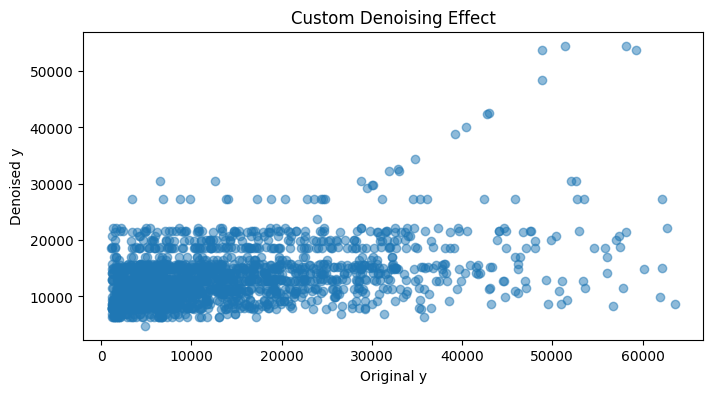

In [14]:
%matplotlib inline
y_denoised = bound_denoise(X, y, length_scale_bounds=(1e-3, 30), noise_level_bounds=(1e-5, 1e3), show_denoising_effect=True)

In [15]:
sr_model = PySRRegressor(
        niterations=1024,  # Number of iterations to search for equations
        binary_operators=["+", "-", "*", "/"],
        unary_operators=["sin", "cos", "exp", "log", "abs", "sqrt"],
        elementwise_loss="loss(x, y) = (x - y)^2",  # Define loss function (mean squared error)
        verbosity=0,
        maxsize=50
    )
sr_model.fit(X, y_denoised)

PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                          13272.203   
	1         0.467379                                      x0 * 337.4581   
	2         0.007559                               (x1 + x0) * 337.5073   
	3         0.488835                         (x0 * exp(x1)) * 330.31763   
	4         0.170878                (x0 * 332.33185) + (x1 * 21903.314)   
	5         0.008134           (x0 + (x1 * (105.137 - x0))) * 332.54633   
	6         0.015005  (((x0 * x0) + (x1 * 5153.543)) * 4.2359533) + ...   
	7         0.194761  ((cos(x1 * x0) * (x0 * 0.009609733)) + x1) * 3...   
	8         0.011083  ((x0 - -286.92993) * (x0 * cos(x1 * x0))) + (x...   
	9         0.044058  ((x0 * 332.97223) * cos(x1 * (x0 + cos(x0)))) ...   
	10        0.006506  ((x0 * 332.92197) * cos((sin(cos(x0)) + x0) * ...   
	11        0.022807  (((cos((cos(x0) + x0) * x1) * 457.42035) + -12...   
	12        0.015927  ((x0 * cos(x1 * (cos(sqrt(x0) - x0) + x0))) * ...   
	13        0.202058  (x0 / cos(0.026959624 * x0)) + (((x0 * 327.779...   
	14        0.003107  (((cos(x0 * x1) * x0) * 327.51596) + ((x0 * 1....   
	15        0.084530  (((cos((cos(x0) + x0) * x1) * x0) * 327.7793) ...   
	16        0.002297  ((x1 * 34277.08) + (((x0 * (4.1990547 * x0)) +...   
	17        0.037049  (x0 / cos(x0 * 0.026959624)) + ((34562.48 * x1...   
	18        0.022377  (x0 / cos(x0 * 0.026959624)) + ((34562.48 * x1...   
	19        0.061421  (cos(x1 * (cos(x0) + x0)) * ((x0 * (x0 * 4.199...   
	20        0.006728  ((x0 / cos(x0 * 0.026922368)) + (cos((x0 + sin...   
	21  >>>>  0.092170  (x1 * 34277.08) + ((cos((cos(x0 * 3.5078382) +...   
	22        0.000116  ((cos((cos(x0 * 3.5078382) + x0) * x1) * (((x0...   
	23        0.068934  (((((x0 * 4.242705) * x0) + 5778.279) * cos(x1...   
	24        0.023935  ((cos(x1 * (x0 + cos((x0 * x0) * 0.8353789))) ...   
	25        0.008677  ((x0 / (cos(x0 * 0.026867488) * 0.66590434)) +...   
	26        0.004241  (((x0 / cos((x0 * 0.026867488) + x1)) * 1.5262...   
	27        0.054338  ((x0 / cos(x0 * -0.026935296)) + (((x0 * ((x0 ...   
	28        0.043122  ((x0 / cos(x0 * 0.026950724)) + (cos(x1 * (x0 ...   
	29        0.039308  (x1 * 34278.793) + (((x0 * 1.5327704) / cos(x0...   
	30        0.007184  ((x1 * 34276.434) + ((x0 * 1.532858) / cos(x0 ...   
	31        0.006399  (x1 * 34278.793) + (((x0 * 1.5327704) / cos(x0...   
	32        0.017058  (cos(x1 * (cos(x0 * (x0 * 0.83535826)) + x0)) ...   
	33        0.004907  (cos(x1 * (cos((x0 * 0.83535826) * x0) + x0)) ...   
	34        0.021062  ((x0 * 1.5327713) / cos(x0 * 0.026890855)) + (...   
	35        0.005593  ((x0 * 1.5189008) / cos(x0 * 0.026890855)) + (...   
	36        0.010375  (((((x0 - (x1 / sin(x0))) * ((x0 - (sin((x0 - ...   
	37        0.009316  (x1 * 34279.348) + (((((x0 - (x1 / sin(x0))) *...   
	38        0.004658  ((x1 * 34279.348) + ((x0 / cos(x0 * 0.02686748...   
	39        0.003985  ((x0 / cos(x0 * 0.026867488)) * 1.6209866) + (...   
	40        0.007174  (cos(x1 * (cos(x0 * (x0 * 0.83535826)) + x0)) ...   
	
	          loss  complexity  
	0   24663832.0           1  
	1    9685019.0           3  
	2    9539693.0           5  
	3    5851079.5           6  
	4    4932017.5           7  
	5    4852432.0           9  
	6    4708973.5          11  
	7    3875634.0          12  
	8    3790674.5          14  
	9    3627289.8          15  
	10   3603765.8          16  
	11   3522505.2          17  
	12   3466847.8          18  
	13   2832578.8          19  
	14   2815033.0          21  
	15   2586857.5          22  
	16   2580921.8          23  
	17   2487049.8          24  
	18   2432015.8          25  
	19   2287134.8          26  
	20   2271799.0          27  
	21   2071767.2          28  
	22   2071526.1          29  
	23   1933539.1          30  
	24   1843159.5          32  
	25   1811450.5          34  
	26   1796152.5          36  
	27   1701156.8      

In [ ]:
# 20250423_213001_XW5234
# Complexity 23
candidate_function = generate_candidate_function("((x1 * 34277.08) + (((x0 * (4.1990547 * x0)) + 5846.4893) * cos(x0 * x1))) + (x0 / cos(x0 * 0.026922368))")

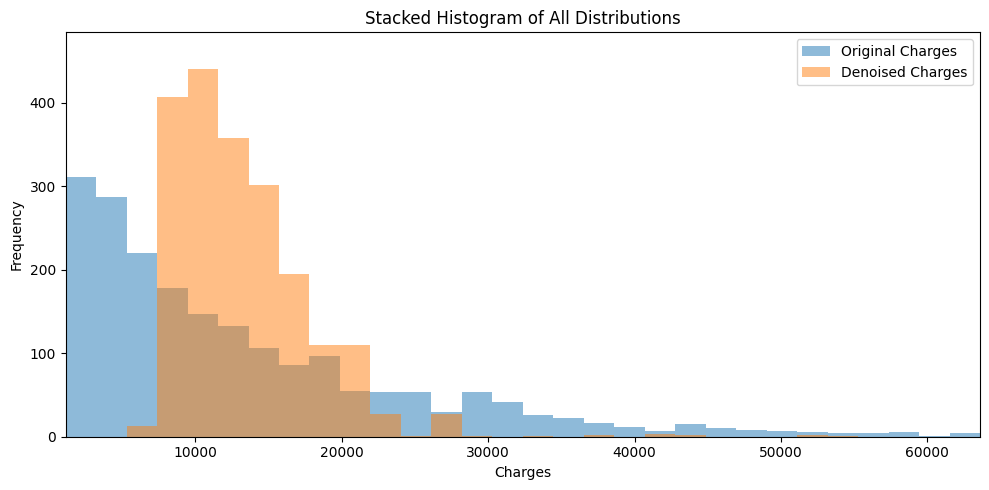

In [25]:
%matplotlib inline
y_denoised = candidate_function(X)
plot_histograms([(y, 'Original Charges', None), (y_denoised, 'Denoised Charges', None)], 'Charges', stack=True, figsize_per_plot=(10, 5))

<Figure size 640x480 with 0 Axes>

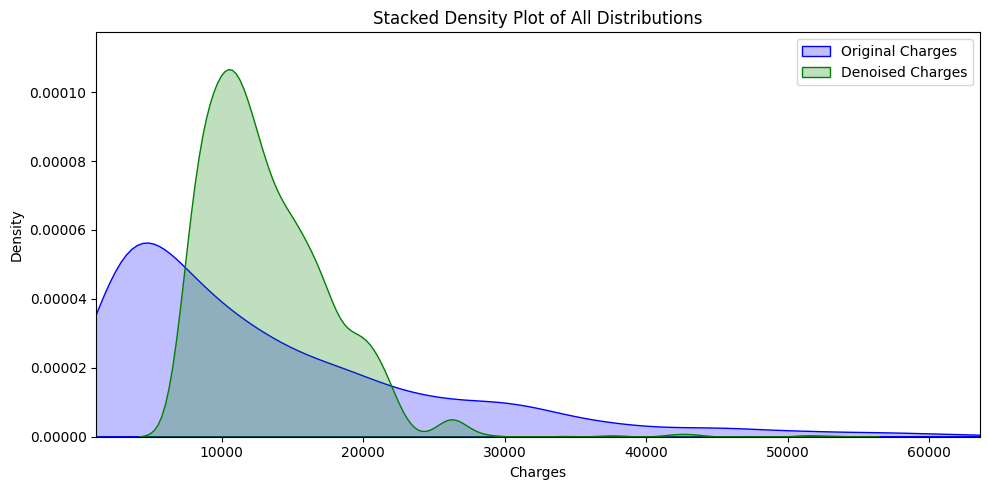

In [26]:
plot_densities([(y, 'Original Charges', 'blue'), (y_denoised, 'Denoised Charges', 'green')], 'Charges', stack=True, figsize_per_plot=(10, 5))

In [27]:
orig_residuals = y - y_denoised

In [29]:
y_renoised, best_amp, errors, _ = renoise_predictions(y, y_denoised, method='stratified', seed=42, clip_lower=0, clip_upper=None, original_residuals=None, tail_replace=True, lower_percentile=50)
# ignore error in orig_residuals after first run

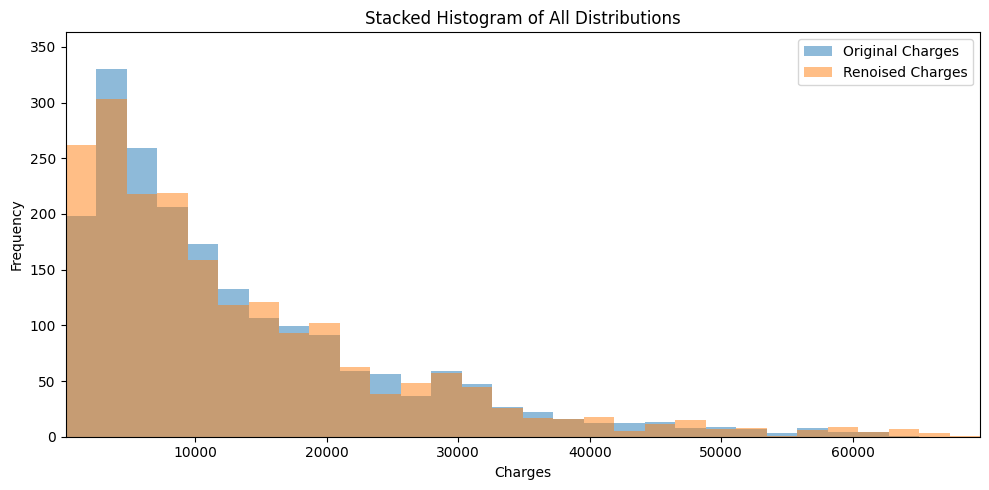

In [30]:
plot_histograms([(y, 'Original Charges', None), (y_renoised, 'Renoised Charges', None)], 'Charges', stack=True, figsize_per_plot=(10, 5))

<Figure size 640x480 with 0 Axes>

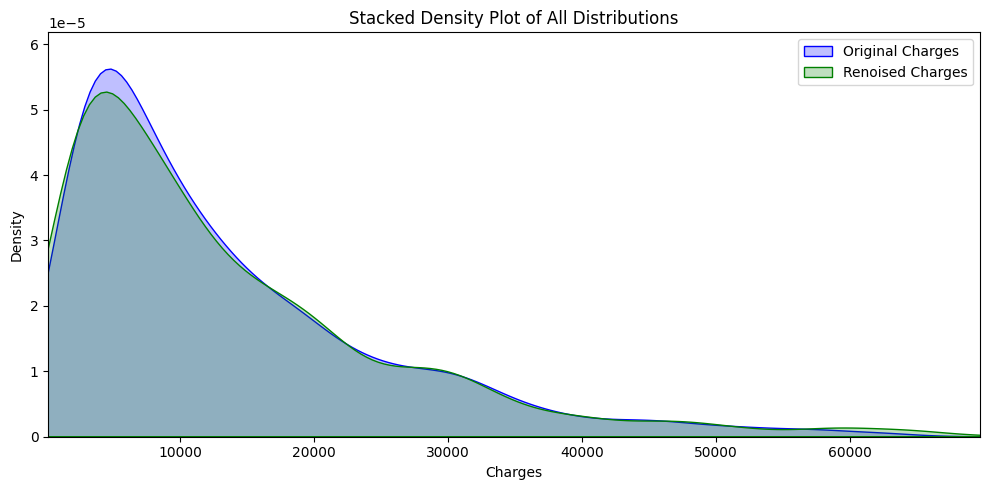

In [31]:
plot_densities([(y, 'Original Charges', 'blue'), (y_renoised, 'Renoised Charges', 'green')], 'Charges', stack=True, figsize_per_plot=(10, 5))

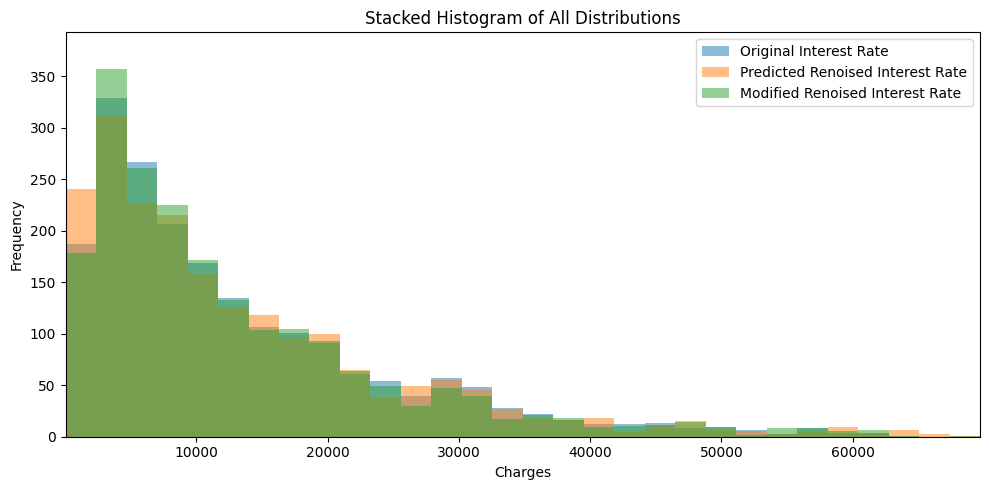

In [35]:
mod_candidate_function = generate_candidate_function("((0.2*x1 * 34277.08) + (((x0 * (4.1990547 * x0)) + 5846.4893) * cos(x0 * 0.2*x1))) + (x0 / cos(x0 * 0.026922368))")
mod_y_pred = mod_candidate_function(X)
mod_y_pred_corrected, best_amp, errors, _ = renoise_predictions(y, mod_y_pred, method='stratified', amplification_factor=1.0, seed=42, clip_lower=0, clip_upper=None, original_residuals=orig_residuals, tail_replace=True, lower_percentile=50)
# ignore error in orig_residuals after first run
plot_histograms([(y, 'Original Interest Rate', None), (y_renoised, 'Predicted Renoised Interest Rate', None), (mod_y_pred_corrected, 'Modified Renoised Interest Rate', None)], 'Charges', stack=True, figsize_per_plot=(10, 5))